# Evolution de l'émission du centre galactique et de l'émission diffuse

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion, RectangleSkyRegion

from gammapy.detect import compute_lima_on_off_image,compute_lima_image # quelle différence entre les deux ?
from gammapy.data import DataStore
from gammapy.irf import make_mean_psf
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.cube import (
    MapDatasetMaker,
    PSFKernel,
    MapDataset,
    RingBackgroundMaker,
    SafeMaskMaker,
    #RingBackgroundEstimator,
)
from gammapy.modeling.models import (
    SkyModel,
    SkyModels,
    BackgroundModel,
    PowerLawSpectralModel,
    PowerLaw2SpectralModel,
    PointSpatialModel,
    ExpCutoffPowerLawSpectralModel,
    SkyDiffuseCube,
    TemplateSpatialModel,
    GaussianSpatialModel
)
from gammapy.stats import significance, excess # utiles ?

from gammapy.modeling import Fit
from astropy.time import Time

src_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

import gammapy
gammapy.__version__

'0.15'

# Début de l'analyse (avec mapdatasets déjà écrits)

## Création de la géométrie

In [7]:
emin, emax = [0.5, 100] * u.TeV

energy_axis = MapAxis.from_bounds(
    emin.value, emax.value, 20, unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",
    axes=[energy_axis],
)

geom2d = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",
)

energy_axis_true = MapAxis.from_bounds(
    0.3, 200, 30, unit="TeV", name="energy", interp="log"
)

## Lecture des cartes

In [8]:
mapdataset_dict = {}

for k in range (2004,2020):
    name = "map" + str(k)
    mapdataset_dict[k] = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name=name)
    
for year in range(2004,2020):
    
    filename = "$GAMMAPY_DATA/mapdataset_hess/mapsdataset_ash_108arcmin/mapdataset" +str(year)+".fits.gz"
    mapdataset_dict[year] = MapDataset.read(filename)

## Modèle de la source

In [9]:
src_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

spatial_model = PointSpatialModel(
            lon_0 = src_pos.l, 
            lat_0 = src_pos.b, 
            frame = "galactic")

spectral_model = PowerLawSpectralModel(
            #emin = 0.5* u.TeV, 
            #emax = 100* u.TeV, 
            reference = 1.0 * u.TeV,
            index = 2.3, 
            amplitude = "2e-12 cm-2 s-1 TeV-1")

model = SkyModel(
            spatial_model = spatial_model, 
            spectral_model = spectral_model, 
            name = "SgrA*")

model.parameters["index"].frozen = True
model.parameters["lon_0"].frozen = True
model.parameters["lat_0"].frozen = True
model.parameters["amplitude"].frozen = False
model.parameters["reference"].frozen = True # change très peu

In [10]:
pos_G09 = SkyCoord(0.8791,  +0.0893, unit="deg", frame="galactic")

spatial_model2 = PointSpatialModel(
            lon_0 = pos_G09.l, 
            lat_0 = pos_G09.b, 
            frame = "galactic")

spectral_model2 = PowerLawSpectralModel(
            #emin = 0.5* u.TeV, 
            #emax = 100* u.TeV, 
            reference = 1.0 * u.TeV,
            index = 2.3, 
            amplitude = "5.5e-13 cm-2 s-1 TeV-1")

modelG09 = SkyModel(
            spatial_model = spatial_model2, 
            spectral_model = spectral_model2, 
            name = "G0901")

modelG09.parameters["index"].frozen = True
modelG09.parameters["lon_0"].frozen = True
modelG09.parameters["lat_0"].frozen = True
modelG09.parameters["amplitude"].frozen = True

## Modèle de l'émission diffuse

On suit larticle de 2018 et on la constitue de 3 composantes. Une qui suit la distribution de gaz (CS) une composante radiale centrale et un composante étendue. On veut fixer leur flux relatif et seulement ajuster un seul facteur de normalisation pour les trois à la fois.

On a les composantes : DGC (Dense Gas Component), CC (Central Component) et LSC (Large Scale Component).

- on prend une carte de la distribution du CS comme base
- on applique une gaussienne pour "atténuer" les bords, car l'émission de rayons gamma suit la distribution du CS à part aux extrémités du "disque centrale"
- on choisit 1.11 deg comme écart-type de la gaussienne
- on seuil les valeurs de la cartes du CS, car celles-ci viennent de données bruitées qui peuvent prendre des valeurs négatives, on veut a priori seuiller un peu au dessus de zéro pour éliminer le bruit autour de zéro
- valeur du seuil : 10
- le fait d'utiliser TemplateSpatialModel en 0.15 conduit à normaliser les valeurs de la carte par leur somme (normal car on va fiter son amplitude), mais aussi par la somme des angles solides, ce qui fait que le spectre obtenu est en sr-1 emais ce n'est précisé nulle part

In [11]:
# GaussianSpatialModel attention pour la composante étendue et les deux sigma

CSmap = Map.read("$GAMMAPY_DATA/CS_reproj.fits") 
# à moduler par une gaussienne en longitude
coords = CSmap.geom.get_coord()
lon = coords.skycoord.l.wrap_at(180*u.deg).to_value('deg')
factor = np.exp(-0.5*(lon)**2/1.11**2) #1.11 quand on a les 3 composantes
CSmap.data*=factor

# seuiller les valeurs pour enlever les valeurs négatives liées au bruit et les petites valeurs positives aussi liées au bruit 
# (du CS ou plutôt de la grandeur utilisées pour le mesurer)

CSmap.data = (CSmap.data > 10.0) * CSmap.data

# peut être un souci ici : on met tout le ciel "vide" à 10 et pas à 0, or c'est grand et ça pose peut être un problème de renormalisation
# trouver une façon de tout mettre à 0 
# CSmap.data.clip(10.0) laisse tout à 10
# CSmap.data.clip(0.0) ne supprime pas la partie "positive" des fluctuations
# on peut faire CSmap.data = (CSmap =< 10) * CSmap.data


# utile pour retrouver la bonne valeur du flux diffus (intégré sur l'angle solide)
# plus bon a priori pour le modèle à trois composantes
solid_angle_tot = CSmap.geom.solid_angle().sum()

geom1000 = CSmap.geom

Invalid value BUNIT='Count' in FITS header. Setting empty unit.


In [12]:
DGC = TemplateSpatialModel(CSmap) 

CC = GaussianSpatialModel(lon_0="0 deg", lat_0="0 deg", sigma="0.11 deg", frame='galactic') #sigma de 0.11

LSC = GaussianSpatialModel(lon_0="0 deg", lat_0="0 deg", sigma="0.97 deg", e=np.sqrt(1-(0.22/0.97)**2), phi="90 deg", frame='galactic') #sigma1 de 0.97 et sigma2 de 0.22, à transformer en sigma et excentricité

In [13]:
# essayer de rassembler les gaussiennes dans un TemplateSpatialModel, voire dans celle de la CSMap

mapCC = CC.evaluate_geom(geom2d)*geom2d.solid_angle()
mapLSC = LSC.evaluate_geom(geom2d)*geom2d.solid_angle()
mapDGC = DGC.evaluate_geom(geom2d)*geom2d.solid_angle()

In [14]:
CCmax = np.max(mapCC)
LSCmax = np.max(mapLSC)
DGCmax = np.max(mapDGC)

mapCC = mapCC/CCmax
mapLSC = mapLSC/LSCmax
mapDGC = mapDGC/DGCmax

In [15]:
data_combine =  4.3*mapDGC + 1.03*mapCC + 2.68*mapLSC # facteurs pour avoir les bons ratios sur les max d'amplitude

#data_combine /= np.sum(data_combine)
# si on supprime la normalisation ?

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7f92938ef2e8>)

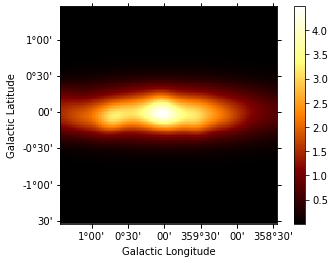

In [16]:
carte = Map.from_geom(geom2d)
carte.quantity = data_combine
carte.cutout(src_pos,3*u.deg).smooth('0.1 deg').plot(add_cbar=True)

In [17]:
DE_spatial = TemplateSpatialModel(carte)

powerlaw1 =  PowerLawSpectralModel(
            reference = 1.0 * u.TeV,
            index = 2.3, 
            amplitude = "7.0e-12 cm-2 s-1 TeV-1")

model_diff = SkyModel(
            spatial_model = DE_spatial, 
            spectral_model = powerlaw1, 
            name = "DE_full")

model_diff.parameters["index"].frozen = True
model_diff.parameters["norm"].frozen = True
model_diff.parameters["amplitude"].frozen = False
model_diff.parameters["reference"].frozen = True

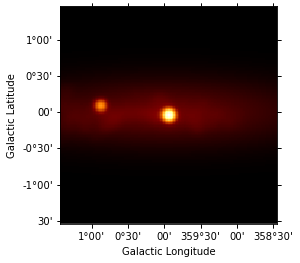

In [18]:
# vérification

mapsgra = model.copy().evaluate_geom(geom)
mapG09 = modelG09.copy().evaluate_geom(geom)
mapdiff = model_diff.copy().evaluate_geom(geom)

maptot1 = mapdiff + mapG09 + mapsgra

carte = Map.from_geom(geom)
carte.quantity = maptot1
carte.cutout(src_pos,3*u.deg).smooth('0.05 deg').plot_interactive()

## Construction du masque

In [19]:
fit_region = RectangleSkyRegion(src_pos, 4*u.deg, 2*u.deg)

bizarre_region = CircleSkyRegion(SkyCoord(358.6,  -0.6, unit="deg", frame="galactic"), 0.5 * u.deg)

fit_mask = geom.region_mask([fit_region])*geom.region_mask([bizarre_region] , inside=False)

fit_mask = Map.from_geom(geom, data=fit_mask)

# Ajustement du modèle aux cartes

Dans le cas de la simulation : on procède normalement jusqu'à mettre les modèles (copiés) dans les dataset

On insère une étape où l'on ajoute des copies des modèles, puis on utilise la méthode fake, qui convolue les modèles par les IRF pour simuler un signal reçu qui correspond au modèle théorique (en supposant que les IRF sont parfaites). Dans l'idée, on veut plutôt utiliser un modèle théorique varaible pour voir si on a la sensibilité pour détecter cette variation.

Puis on fait l'analyse normale en mettant (une autre) copie des modèles dans les datasets pour voir si l'on retrouve le modèle théorique.

Pour l'instant (juillet 2020) ça ne fonctionne pas vraiment, ou de manière irrégulière.

In [20]:
def fit_dataset(mapdataset):
    
    """
    Fonction pour ajuster le modèle du dataset aux données, il faut la modifier pour chaque ensemble de paramètres désiré, 
    mais aussi quand on change de modèle (car les indices associés aux différents paramètres changent)
    
    Elle retourne :
    - une table avec les paramètres qui nous intéresse
    - la matrice de covariance
    - l'objet "résultat" du fit (savoir s'il a échoué ou réussi)
    """
    
    fit = Fit([mapdataset])
    result = fit.run()
    
    table = result.parameters.to_table()
    
    rescov = fit.covariance()
    ampSGRA = mapdataset.models.parameters[3]
    ampdiff = mapdataset.models.parameters[12]
    normbkg = mapdataset.background_model.parameters['norm']
    
    cov= rescov.parameters.get_subcovariance([ampSGRA, ampdiff, normbkg])
    
    return table, cov, result

def fit_dataset_contour(mapdataset):
    """
    Fonction censée calculer le contour
    """
    fit = Fit([mapdataset])

    fit.optimize()
    res = fit.minos_contour(3, 12)
   
    return res

# Création des fausses cartes

problème : quand on regarde les donnée, il n'y a pas de coups correcpondants au diffus (ça a marché une fois), 
soit c'est la fonction fake qui a un problème (oui), soit il manque un (gros) facteur multiplicatif pour model_diff (non)
    
si on ne met que le modèle du diffus (3 composantes) le résultat ne semble pas contenir le modèle voulu
    
si on met le diffus (3 comp) et les 2 sources ponctuelles, il y a bien les sources, mais le diffus ne se vois pas à l'oeil (il devrait), 
ni avec stretch='log' \
l'ajustement échoue pour 2009, 2011, 2012,2015,2018, le diffus est négatif pour certaines années

si on met le diffus (1 comp, DGC) et les 2 sources ponctuelles, c'est à peu près pareil (ça échoue pour plusieurs années)

In [21]:
# rajouter une étape pour modifier les valeurs d'amplitude année par année (pour la source centrale) éventuellement à partir des résultats du vrai fit

# tester plusieurs

In [22]:
for year in range(2004,2020):
    mapdataset_dict[year].models = model.copy() + modelG09.copy() + model_diff.copy() 
    mapdataset_dict[year].fake() #le problème est là, la fonction fake crée une carte de coups sans emission diffuse apparente

/home/samuel/anaconda3/envs/gammapy-0.15/lib/python3.7/site-packages/gammapy/cube/psf_kernel.py:109: RuntimeWarning: invalid value encountered in true_divide
  img += vals.value / vals.sum().value


(<Figure size 432x288 with 1 Axes>,
 None)

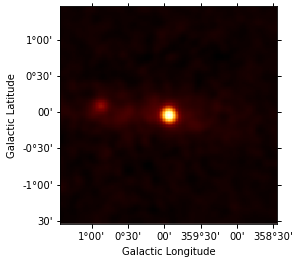

In [23]:
# Affichage de la carte des coups moins le fond (sachant qu'ici ce sont les faux coups obtenus par la méthode .fake())

count = mapdataset_dict[2004].counts
bkg = mapdataset_dict[2004].background_model.evaluate()
excess = count-bkg
excess.sum_over_axes().cutout(src_pos,3*u.deg).smooth('0.05 deg').plot()

# Ajustement des données simulées

In [24]:
%%time
# pas de souci si on fait tout normalement

for year in range(2004,2020):
    mapdataset_dict[year].fit_mask = fit_mask
    mapdataset_dict[year].models =  model.copy() + modelG09.copy()+ model_diff.copy()
    
    #mapdataset_dict[year].background_model.parameters['norm'].value = 1.0
    mapdataset_dict[year].background_model.parameters['norm'].frozen = False


/home/samuel/anaconda3/envs/gammapy-0.15/lib/python3.7/site-packages/gammapy/cube/psf_kernel.py:109: RuntimeWarning: invalid value encountered in true_divide
  img += vals.value / vals.sum().value


CPU times: user 13.2 s, sys: 87.2 ms, total: 13.3 s
Wall time: 13.2 s


(<Figure size 432x288 with 1 Axes>,
 None)

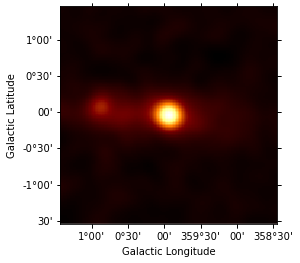

In [25]:
# Affichage des coups - fond (a priori pas de différence avec la même chose plus haut, ça fait doublons)

count = mapdataset_dict[2004].counts
bkg = mapdataset_dict[2004].background_model.evaluate()
excess = count - bkg
excess.sum_over_axes().cutout(src_pos,3*u.deg).smooth('0.1 deg').plot()

In [26]:
%%time

results_per_year = dict()
results = []
cov_per_year = dict()


for year in range(2004,2020):
    
    table, cov, result = fit_dataset(mapdataset_dict[year])
    
    results.append(result)
    
    results_per_year[year] = table
    
    cov_per_year[year] = cov
    

CPU times: user 9min 47s, sys: 46.2 s, total: 10min 33s
Wall time: 10min 33s


In [27]:
# afficher les résultats des ajustements pour toutes les années (pas très clair)
print(results)

[OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 61
	total stat : 395856.92
, OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 63
	total stat : 445988.24
, OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 60
	total stat : 227056.75
, OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 54
	total stat : 73865.35
, OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 68
	total stat : 130287.35
, OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev      

In [28]:
# Pour afficher les résultats d'une années particulière
results_per_year[2006]

name,value,error,unit,min,max,frozen
str9,float64,float64,str14,float64,float64,bool
lon_0,3.599e+02,0.000e+00,deg,nan,nan,True
lat_0,-4.000e-02,0.000e+00,deg,-9.000e+01,9.000e+01,True
index,2.300e+00,0.000e+00,,nan,nan,True
amplitude,2.117e-12,1.360e-13,cm-2 s-1 TeV-1,nan,nan,False
reference,1.000e+00,0.000e+00,TeV,nan,nan,True
lon_0,8.791e-01,0.000e+00,deg,nan,nan,True
lat_0,8.930e-02,0.000e+00,deg,-9.000e+01,9.000e+01,True
index,2.300e+00,0.000e+00,,nan,nan,True
amplitude,5.500e-13,0.000e+00,cm-2 s-1 TeV-1,nan,nan,True


### Sauvegarde des modèles par année

In [29]:
from pathlib import Path

path = Path("../../../hess_results/simu_DE_1comp_24juil/")
path.mkdir(exist_ok=True)

In [30]:
pathm = Path(path / "models")
pathm.mkdir(exist_ok=True)

for year in range(2004,2020):
    name = "model"+ str(year)
    mapdataset_dict[year].models.write(pathm/name, overwrite=True)

### Affichage et sauvegarde des résidus

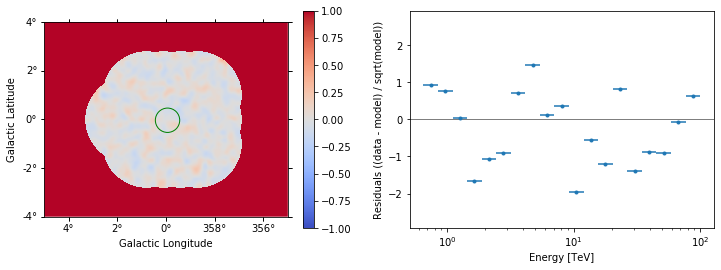

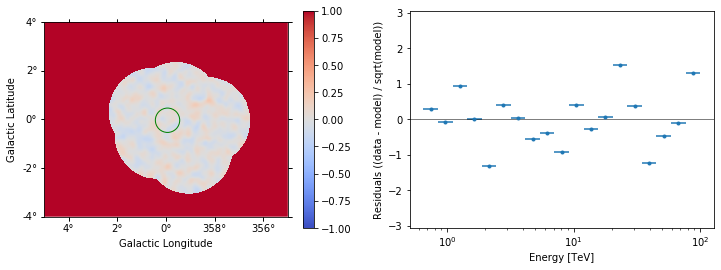

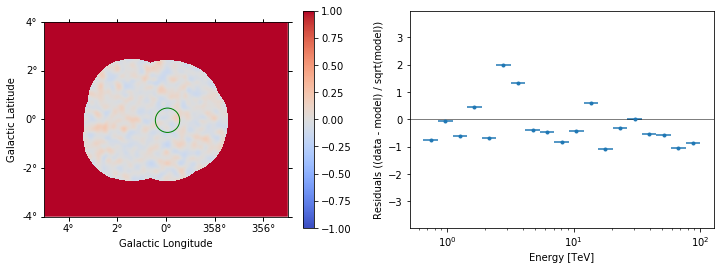

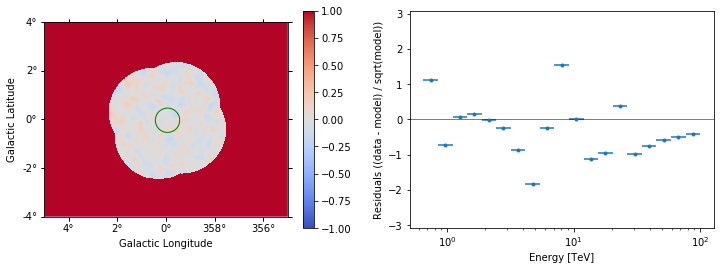

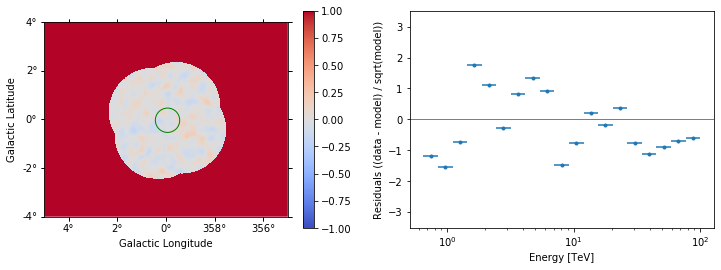

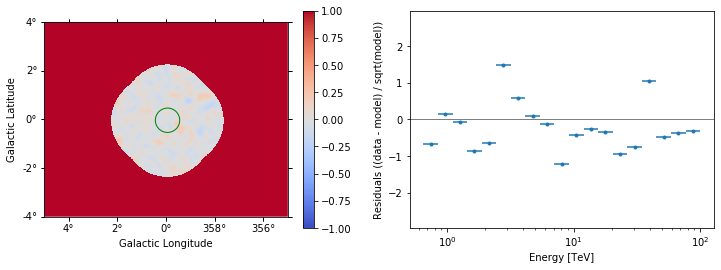

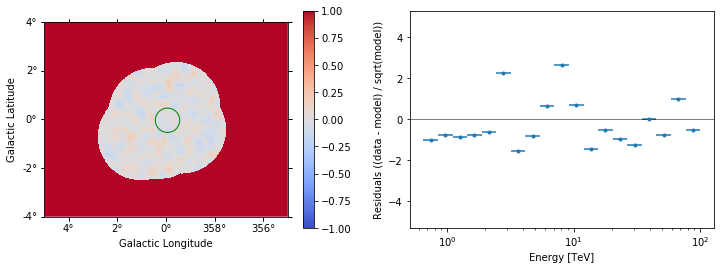

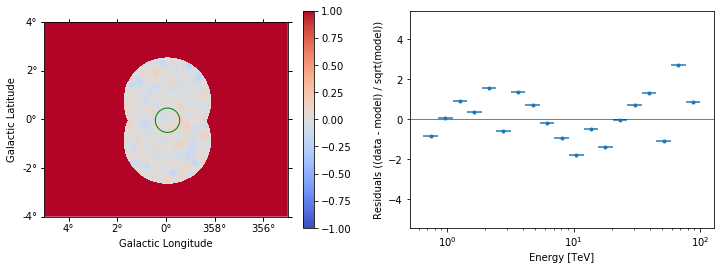

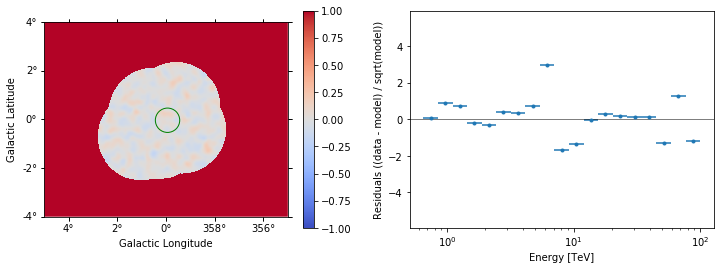

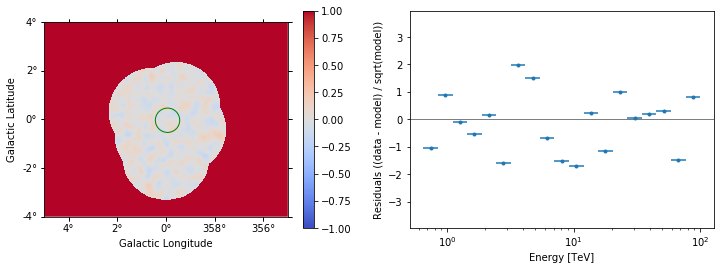

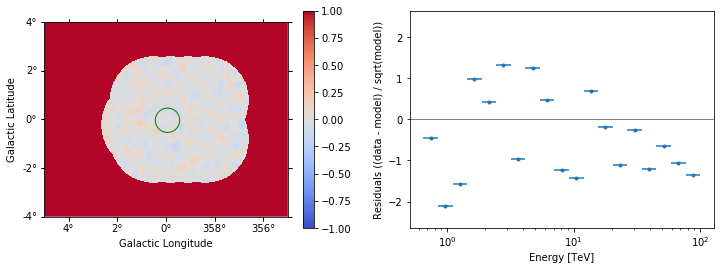

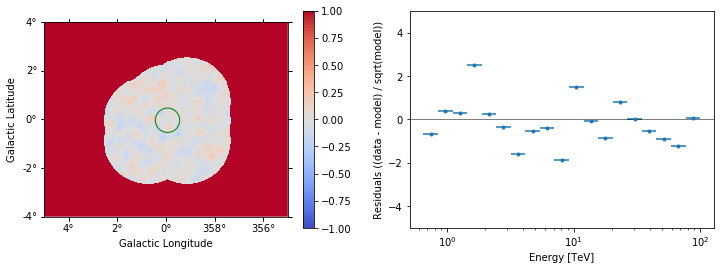

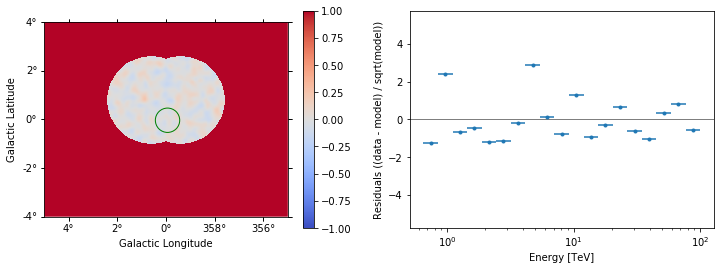

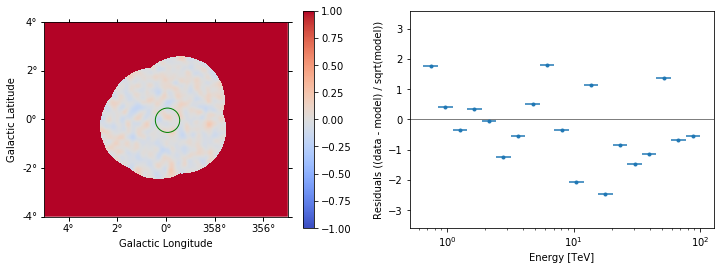

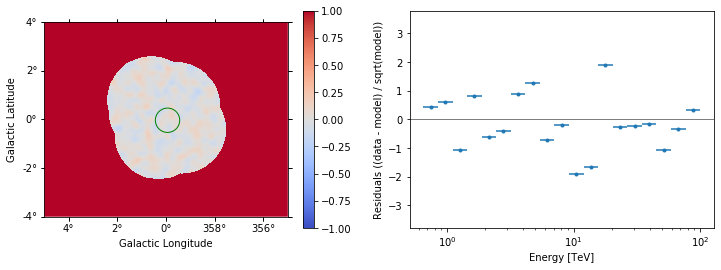

In [31]:
region = CircleSkyRegion(
    center=src_pos, radius=0.5 * u.deg
)

pathr = Path(path/"residuals")
pathr.mkdir(exist_ok=True)

for year in range(2004,2017):
    mapdataset_dict[year].plot_residuals(
        region=region, method="diff/sqrt(model)", vmin=-1.0, vmax=1.0
        )
    name = "residuals_"+str(year)+".pdf"
    plt.savefig(pathr/name, overwrite=True)

for year in range(2018,2020):
    mapdataset_dict[year].plot_residuals(
        region=region, method="diff/sqrt(model)", vmin=-1.0, vmax=1.0
        )
    name = "residuals_"+str(year)+".pdf"
    plt.savefig(pathr/name, overwrite=True)

# Significativité

à faire, couper la source qui reste et faire un plot des résidus avec la significativité

la méthode "simple" c'est $(n_{on} - µ_{bkg})/\sqrt{µ_{bkg}}$ (déjà fait par la méthod diff/sqrt(model)

la méthode "lima" : $S_{lima} = \sqrt{2} \left[
          n_{on} \log \left( \frac{n_{on}}{\mu_{bkg}} \right) - n_{on} + \mu_{bkg}
        \right] ^ {1/2}$
        
Traduit ici le fond devient le modèle et le nombre de coups "on" est juste le vrai nombre de coups

### Significativité par rapport au fond

/home/samuel/anaconda3/envs/gammapy-0.15/lib/python3.7/site-packages/gammapy/stats/poisson.py:245: RuntimeWarning: divide by zero encountered in true_divide
  val = np.sqrt(2) * np.sqrt(n_on * np.log(n_on / mu_bkg) - n_on + mu_bkg)
/home/samuel/anaconda3/envs/gammapy-0.15/lib/python3.7/site-packages/gammapy/stats/poisson.py:245: RuntimeWarning: invalid value encountered in log
  val = np.sqrt(2) * np.sqrt(n_on * np.log(n_on / mu_bkg) - n_on + mu_bkg)
/home/samuel/anaconda3/envs/gammapy-0.15/lib/python3.7/site-packages/gammapy/stats/poisson.py:245: RuntimeWarning: invalid value encountered in log
  val = np.sqrt(2) * np.sqrt(n_on * np.log(n_on / mu_bkg) - n_on + mu_bkg)
/home/samuel/anaconda3/envs/gammapy-0.15/lib/python3.7/site-packages/gammapy/stats/poisson.py:245: RuntimeWarning: divide by zero encountered in true_divide
  val = np.sqrt(2) * np.sqrt(n_on * np.log(n_on / mu_bkg) - n_on + mu_bkg)
/home/samuel/anaconda3/envs/gammapy-0.15/lib/python3.7/site-packages/gammapy/stats/poisson

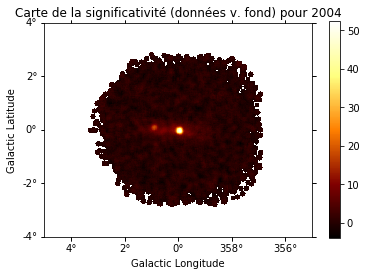

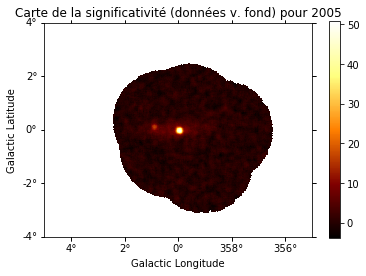

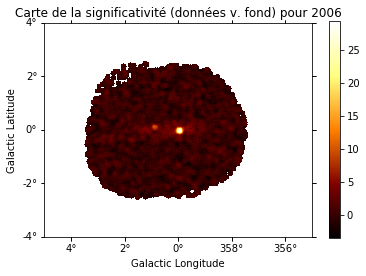

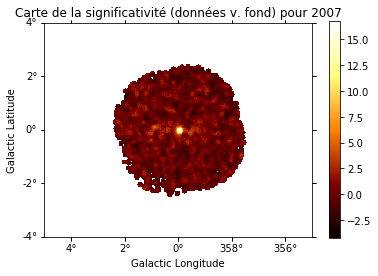

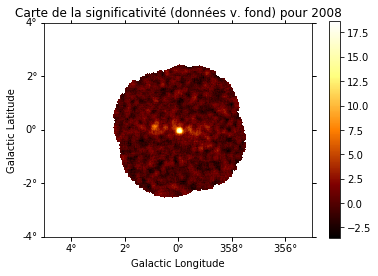

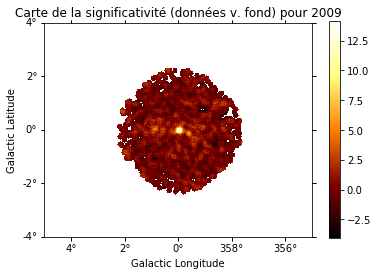

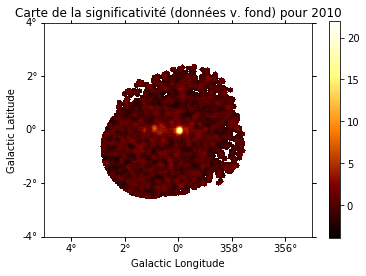

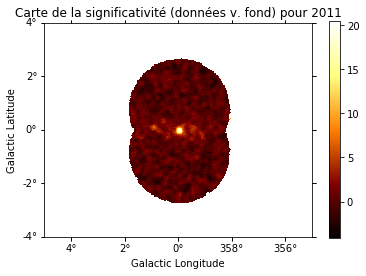

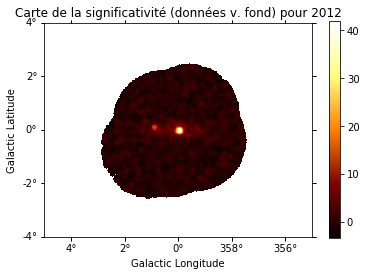

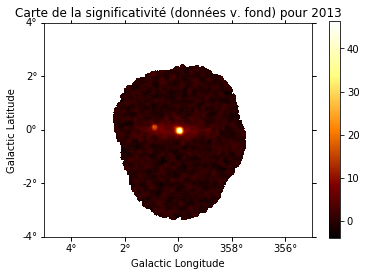

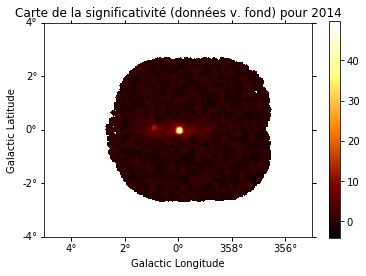

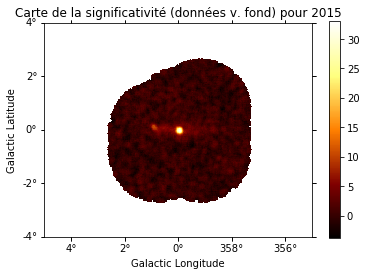

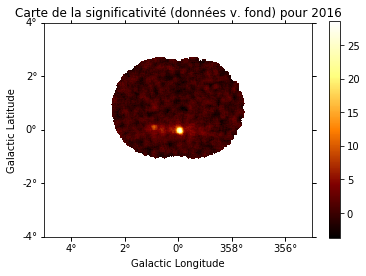

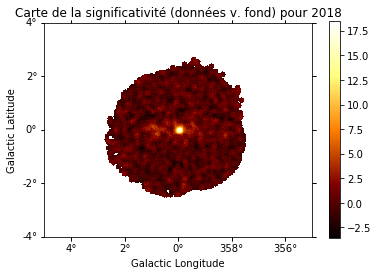

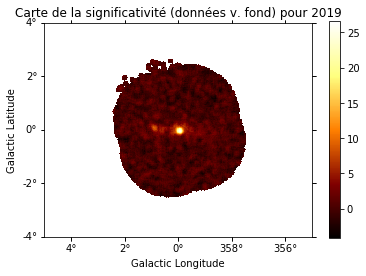

In [32]:
# compute_lima_image(counts, bkg, kernel) # trouver le kernel à utiliser ici
paths = Path(path/"significance_v_bkg")
paths.mkdir(exist_ok=True)

kernel = Tophat2DKernel(5) # il faut élargir la région où l'on compte les coups pour calculer la significativité, ici on prend 5 bin en distance angulaire par ex

lima_significances = dict()

for year in range(2004,2017):
    plt.figure()
    counts = mapdataset_dict[year].counts.sum_over_axes()
    bkg = mapdataset_dict[year].background_model.evaluate().sum_over_axes()
    lima_significances[year] = compute_lima_image(counts, bkg, kernel)
    
    lima_significances[year]['significance'].plot(add_cbar=True)
    name = "significance_"+str(year)+".pdf"
    plt.title("Carte de la significativité (données v. fond) pour "+str(year))
    plt.savefig(paths/name, overwrite=True)

for year in range(2018,2020):
    plt.figure()
    counts = mapdataset_dict[year].counts.sum_over_axes()
    bkg = mapdataset_dict[year].background_model.evaluate().sum_over_axes()
    lima_significances[year] = compute_lima_image(counts, bkg, kernel)
    
    lima_significances[year]['significance'].plot(add_cbar=True)
    name = "significance_"+str(year)+".pdf"
    plt.title("Carte de la significativité (données v. fond) pour "+str(year))
    plt.savefig(paths/name, overwrite=True)

### Significativité par rapport au modèle (nombre de coups prédits)

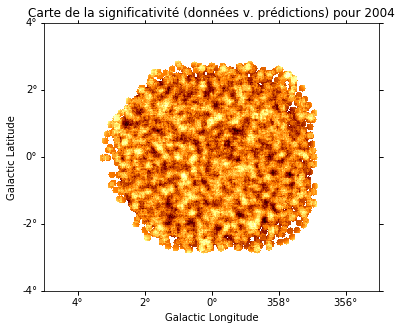

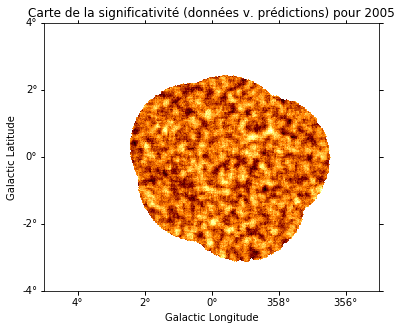

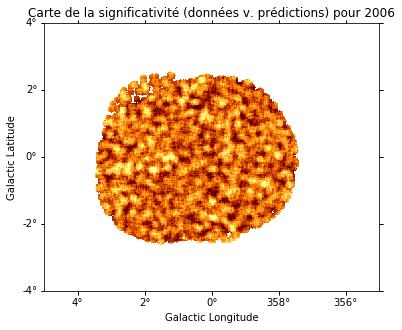

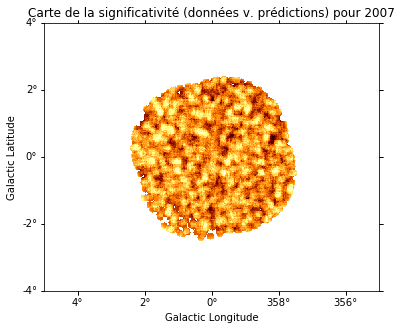

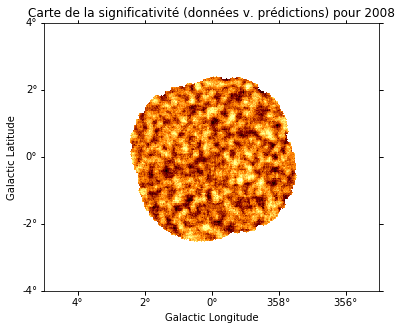

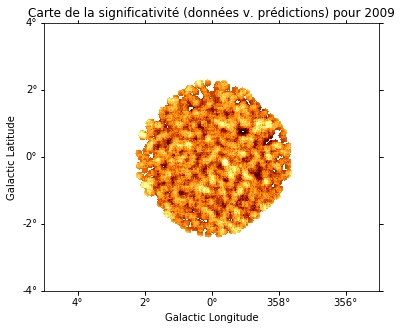

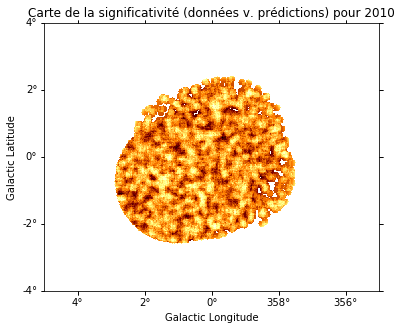

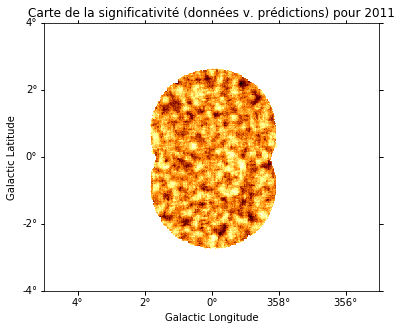

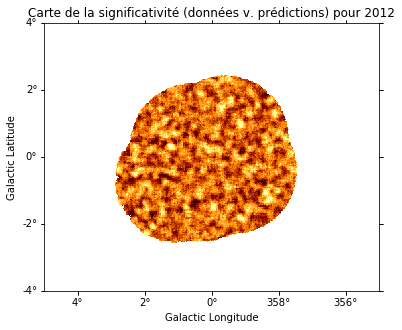

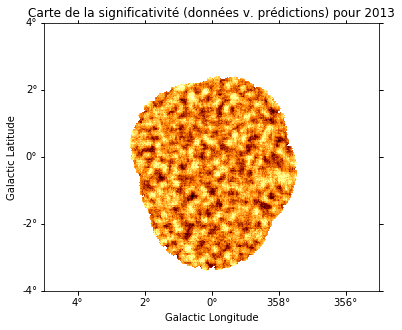

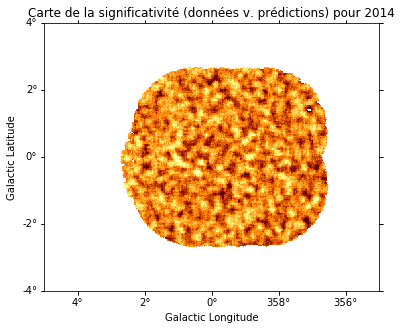

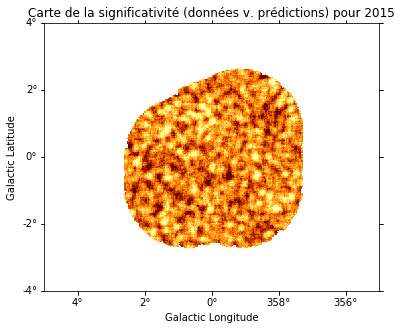

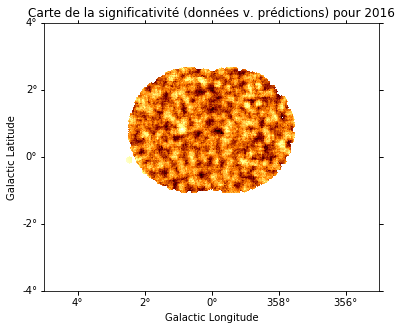

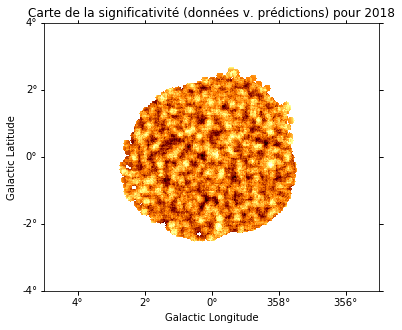

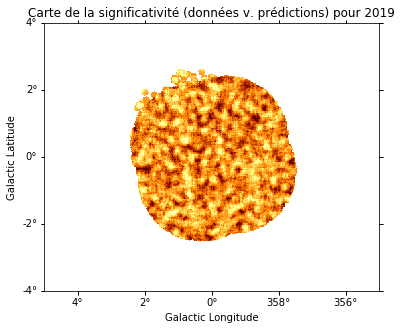

In [33]:
paths = Path(path/"significance_v_npred")
paths.mkdir(exist_ok=True)

kernel = Tophat2DKernel(5) # il faut élargir la région où l'on compte les coups pour calculer la significativité, ici on prend 5 bin en distance angulaire par ex

lima_significances = dict()

for year in range(2004,2017):
    plt.figure(figsize=(6,6))
    counts = mapdataset_dict[year].counts.sum_over_axes()
    mod = mapdataset_dict[year].npred().sum_over_axes()
    lima_significances[year] = compute_lima_image(counts, mod, kernel)
    
    lima_significances[year]['significance'].plot()
    name = "significance_"+str(year)+".pdf"
    plt.title("Carte de la significativité (données v. prédictions) pour "+str(year))
    plt.savefig(paths/name, overwrite=True)

for year in range(2018,2020):
    plt.figure(figsize=(6,6))
    counts = mapdataset_dict[year].counts.sum_over_axes()
    mod = mapdataset_dict[year].npred().sum_over_axes()
    lima_significances[year] = compute_lima_image(counts, mod, kernel)
    
    lima_significances[year]['significance'].plot()
    name = "significance_"+str(year)+".pdf"
    plt.title("Carte de la significativité (données v. prédictions) pour "+str(year))
    plt.savefig(paths/name, overwrite=True)

/home/samuel/anaconda3/envs/gammapy-0.15/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/samuel/anaconda3/envs/gammapy-0.15/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/samuel/anaconda3/envs/gammapy-0.15/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:897: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
/home/samuel/anaconda3/envs/gammapy-0.15/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:897: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)


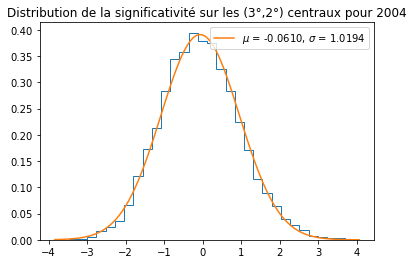

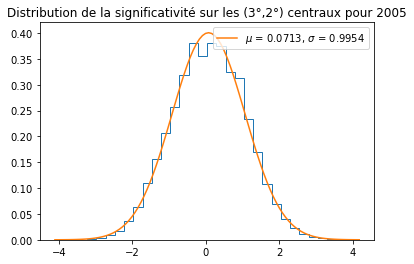

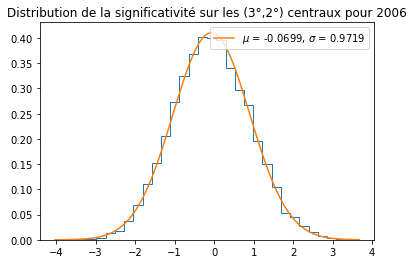

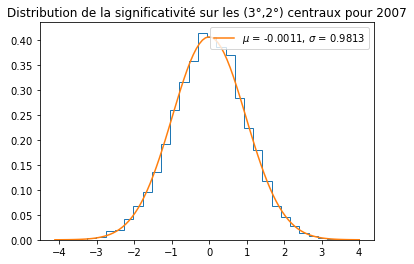

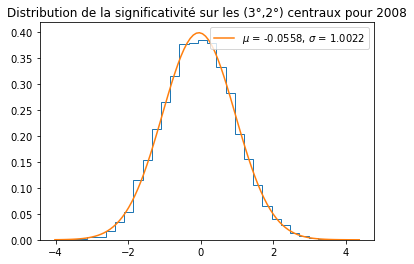

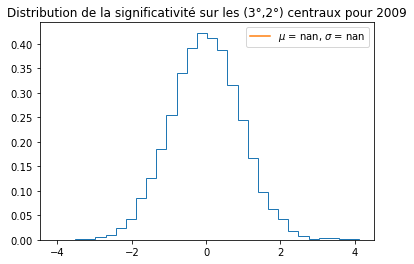

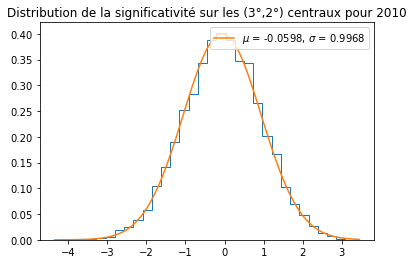

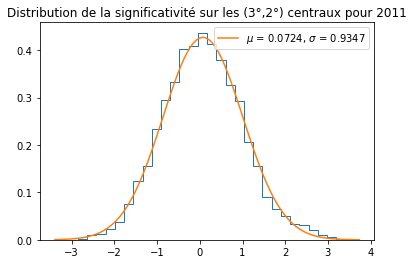

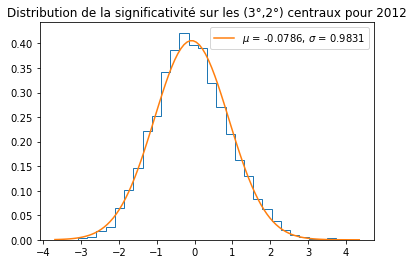

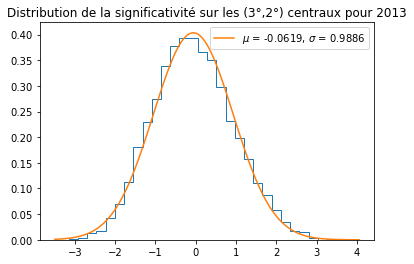

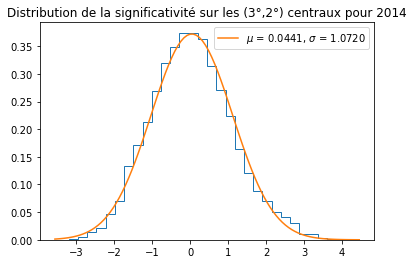

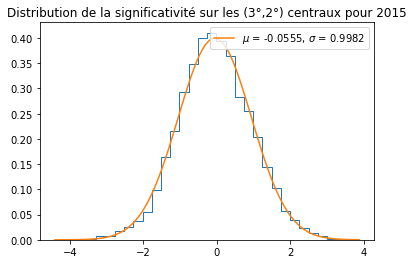

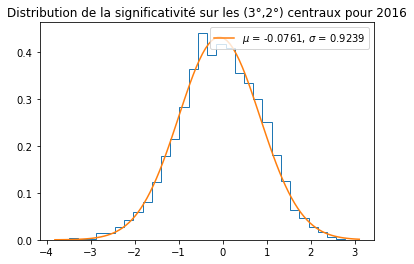

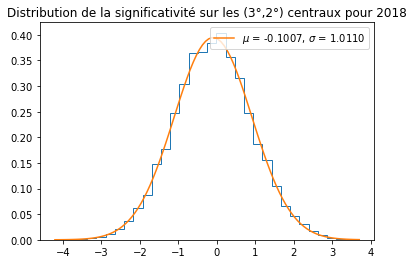

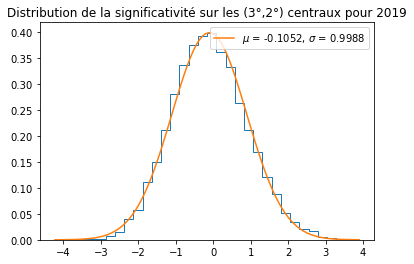

In [63]:
# on veut voir la distribution des significativité dans cette région (par ex)
# souci avec 2009 et 2010 ?

from scipy.stats import norm

pathh = Path(paths/"significance_histo")
pathh.mkdir(exist_ok=True)

for year in range(2004,2017):
    plt.figure()
    signidata = lima_significances[year]['significance'].cutout(position=src_pos, width=(3 * u.deg, 1.5* u.deg)).data
    
    # on masque la région en bas à droite
    mask = fit_mask.reduce_over_axes(func=np.logical_or).cutout(position=src_pos, width=(3 * u.deg, 1.5 * u.deg)).data

    plt.hist(signidata[mask].flatten(),30, histtype='step', density=True)
    
    mean,std=norm.fit(signidata[mask])
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    y = norm.pdf(x, mean, std)
    plt.plot(x, y, label=r'$\mu$ = {0:03.4f}, $\sigma$ = {1:03.4f}'.format(mean,std))
    
    plt.legend(loc=1)
    
    name = "significance_hist"+str(year)+".pdf"
    plt.title("Distribution de la significativité sur les (3°,2°) centraux pour "+str(year))
    plt.savefig(pathh/name, overwrite=True)
    
for year in range(2018,2020):
    plt.figure()
    signidata = lima_significances[year]['significance'].cutout(position=src_pos, width=(3 * u.deg, 2 * u.deg)).data
    
    # on masque la région en bas à droite
    mask = fit_mask.reduce_over_axes(func=np.logical_or).cutout(position=src_pos, width=(3 * u.deg, 2 * u.deg)).data

    plt.hist(signidata[mask].flatten(),30, histtype='step', density=True)
    
    mean,std=norm.fit(signidata[mask])
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    y = norm.pdf(x, mean, std)
    plt.plot(x, y, label=r'$\mu$ = {0:03.4f}, $\sigma$ = {1:03.4f}'.format(mean,std))
    
    plt.legend(loc=1)
    
    name = "significance_hist"+str(year)+".pdf"
    plt.title("Distribution de la significativité sur les (3°,2°) centraux pour "+str(year))
    plt.savefig(pathh/name, overwrite=True)

## Etude de l'évolution temporelle de la source/du diffus

In [35]:
def CalculateFluxFromModels(year, emin, emax):
    GC_model, G09, DE_model  = mapdataset_dict[year].models
    

    
    amplitudeGC = results_per_year[year]['value'][3]
    amp_errGC = results_per_year[year]['error'][3]
    amplitudediff = results_per_year[year]['value'][12]
    amp_errdiff = results_per_year[year]['error'][12]

    norm = results_per_year[year]['value'][14]
    norm_err = results_per_year[year]['error'][14]
    
    if isinstance(emin, u.Quantity):
        #il faut convertir le flux du diffus qui est en sr-1, 
        # donc intégrer sur tout l'angle solide du template (opération inverse de celle effectuée par TamplateSpatialModel)
        
        diffuse_flux = DE_model.spectral_model.integral(emin, emax)*solid_angle_tot/u.sr  
        GC_flux = GC_model.spectral_model.integral(emin, emax)
        
    if np.isscalar(emin):
        emin = emin*u.TeV
        emax = emax*u.TeV
        diffuse_flux = DE_model.spectral_model.integral(emin, emax)
        GC_flux = GC_model.spectral_model.integral(emin, emax)
    
    return diffuse_flux, GC_flux, amplitudeGC, amp_errGC, amplitudediff, amp_errdiff, norm, norm_err


    #diffuse_index = diffuse_model.spectral_model.index.value
    #diffuse_amp = diffuse_model.spectral_model.amplitude.value
    
    #GC_index = GC_model.spectral_model.index.value
    #GC_amp = GC_model.spectral_model.amplitude.value
     

## Tracé de l'évolution

Problèmes actuels :
- l'émission diffuse varie trop (au moins du simple au double)
- l'émission diffuse n'est plus calculabe à partir de 2017
- l'émission diffuse croit "linéairement" en deux temps, pourquoi ?
- le flux de la source évolue clairement avec le flux du diffus, c'est attendu mais cela implique que les valeurs calculées pour le flux de la source sont faussés.
- le fond a une normalisation qui varie trop apparemment

In [36]:
emin = 1.0*u.TeV
emax = 10*u.TeV
resGC = []
resdiff = []
ampsGC = []
amp_errsGC = []
ampsdiff = []
amp_errsdiff = []
norms = []
norms_err = []


for year in range(2004,2017):
    dif , GC, amp, amp_err, ampdiff, amp_errdiff, norm, norm_err = CalculateFluxFromModels(year, emin, emax)
    
    resGC.append(GC.value)
    resdiff.append(dif.value)
    ampsGC.append(amp)
    amp_errsGC.append(amp_err)
    ampsdiff.append(ampdiff)
    amp_errsdiff.append(amp_errdiff)
   
    
    norms.append(norm)
    norms_err.append(norm_err)
    
for year in range(2018,2020):
    dif , GC, amp, amp_err, ampdiff, amp_errdiff, norm, norm_err = CalculateFluxFromModels(year, emin, emax)
    
    resGC.append(GC.value)
    resdiff.append(dif.value)
    ampsGC.append(amp)
    amp_errsGC.append(amp_err)
    ampsdiff.append(ampdiff)
    amp_errsdiff.append(amp_errdiff)
   
    
    norms.append(norm)
    norms_err.append(norm_err)
    
resGC = np.asarray(resGC)
ampsGC = np.asarray(ampsGC)
amp_errsGC = np.asarray(amp_errsGC)
resdiff = np.asarray(resdiff)
ampsdiff = np.asarray(ampsdiff)
amp_errsdiff = np.asarray(amp_errsdiff)
norms = np.asarray(norms)
norms_err = np.asarray(norms_err)

In [37]:
yerrGC = (resGC/ampsGC)*amp_errsGC
yerrdiff = (resdiff/ampsdiff)*amp_errsdiff


bizar = []
for k in range(13):
    truc = 2*(cov_per_year[2004+k][0,1]*yerrGC[k]*yerrdiff[k])/(resGC[k]*resdiff[k])
    bizar.append(truc)
    
for k in range(2):
    truc = 2*(cov_per_year[2018+k][0,1]*yerrGC[13+k]*yerrdiff[13+k])/(resGC[13+k]*resdiff[13+k])
    bizar.append(truc)    

# erreurs quadratiques trop simplistes car les jeux de données sont corrélées
yerr_rap = (resGC/resdiff)*np.sqrt((yerrGC/resGC)**2 + (yerrdiff/resdiff)**2 -bizar )

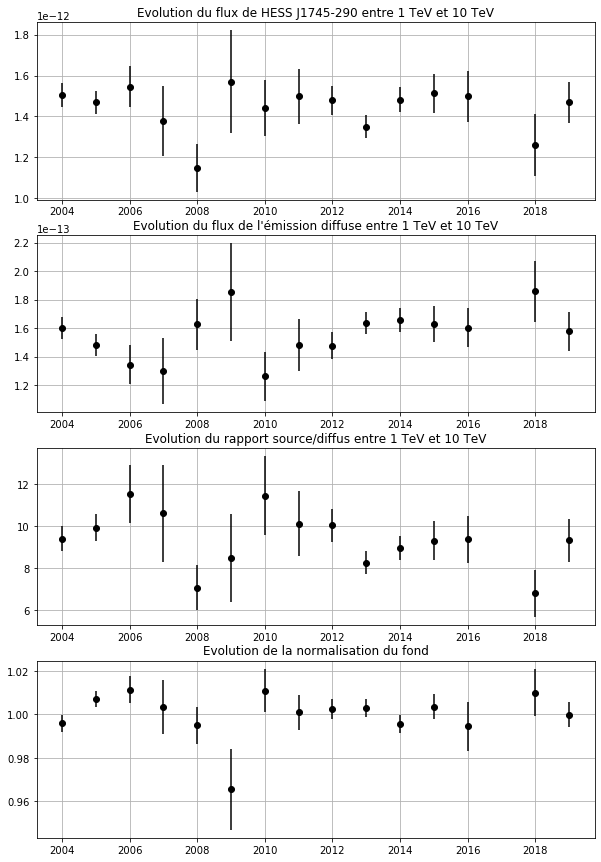

In [38]:
years = [k for k in range(2004,2017)]+[2018,2019]


plt.figure(figsize=(10,15))

ax1 = plt.subplot(4,1,1)

plt.errorbar(years , resGC, yerr=yerrGC, fmt='ko')# ax=ax1)
plt.title("Evolution du flux de HESS J1745-290 entre 1 TeV et 10 TeV")
plt.grid()

ax2 = plt.subplot(4,1,2)
plt.errorbar(years , resdiff, yerr=yerrdiff, fmt='ko')
plt.title("Evolution du flux de l'émission diffuse entre 1 TeV et 10 TeV")
plt.grid()

ax2 = plt.subplot(4,1,3)
plt.errorbar(years , resGC/resdiff, yerr=yerr_rap, fmt='ko')
plt.title("Evolution du rapport source/diffus entre 1 TeV et 10 TeV")
plt.grid()


ax4 = plt.subplot(4,1,4)
plt.errorbar(years , norms, yerr=norms_err, fmt='ko')# ax=ax1)
plt.title("Evolution de la normalisation du fond")
plt.grid()

plt.savefig(path/"GCDEflux_evolution_04_19_full.pdf")

## Ajustement du modèle d'évolution grâce à astropy

In [54]:
import scipy.stats as stats

from astropy.modeling import models, fitting

from scipy.stats import chi2



def chisq(obs, exp, error):
    chisq = 0
    for i in range(len(obs)):
        chisq = chisq + ((obs[i]-exp)**2)/(error[i]**2)
    return chisq


def chisqr(obs, exp, error):
    chisqr = 0
    for i in range(len(obs)):
        chisqr = chisqr + ((obs[i]-exp)**2)/(error[i]**2)
    return chisqr/(len(obs) -1)

def pval(obs,exp, error):
    chisquare = chisq(obs,exp,error)
    nddl = len(obs)
    return chi2.sf(chisquare, nddl)

### Ajustement de l'évolution de la source

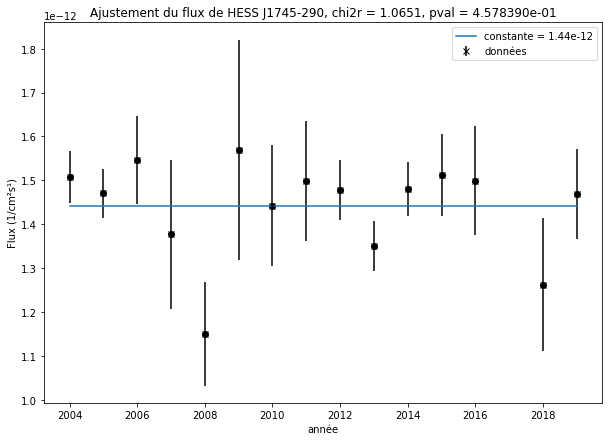

In [55]:
x = years
y = resGC
y_uncs = yerrGC


# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(1e-12)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y) #, weights=1.0/y_uncs)

# évaluation du chi2 réduit
A1 = y
A2 = t(2004)
err_bars = y_uncs
#chi2, pval = stats.chisquare(y, A2)
chi2r = chisqr(A1, A2, err_bars)

pv = pval(A1, A2,err_bars)


# Plot the data with the best-fit model
plt.figure(figsize=(10,7))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="données")
plt.plot(x, t(x), label='constante = ' + str(round(t(2004), 14)) )
plt.xlabel('année')
plt.ylabel('Flux (1/cm²s¹)')
plt.legend(loc=1)
plt.title("Ajustement du flux de HESS J1745-290, chi2r = {0:03.4f}, pval = {1:e}".format(chi2r, pv))
plt.savefig(path/"fit_flux_SgrAstar_04_19_full.pdf")

On peut supposer que les erreurs qu'on voit ici sont typiques, pour prédir le genre de variations qu'on a pour chaque simulation sans refaire les simulations 100 fois (dans un premier temps)

### Ajustement de l'émission diffuse

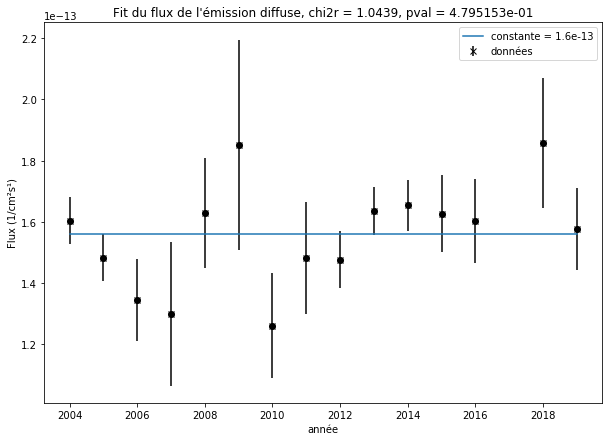

In [64]:
x = years
y = resdiff
y_uncs = yerrdiff



# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(1e-10)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y)#, weights=1.0/y_uncs)

A1 = y
A2 = t(2004)
err_bars = y_uncs
#chi2, pval = stats.chisquare(A1, A2)
chi2r = chisqr(A1, A2, err_bars)

pv = pval(A1, A2, err_bars)

# Plot the data with the best-fit model
plt.figure(figsize=(10,7))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="données")
plt.plot(x, t(x), label='constante = ' + str(round(t(2004), 14)) )
plt.xlabel('année')
plt.ylabel('Flux (1/cm²s¹)')
plt.legend(loc=1)
plt.title("Fit du flux de l'émission diffuse, chi2r = {0:03.4f}, pval = {1:e}".format(chi2r, pv))
plt.savefig(path/"fit_flux_DE_04_19_full.pdf")

### On regarde le rapport entre les 2

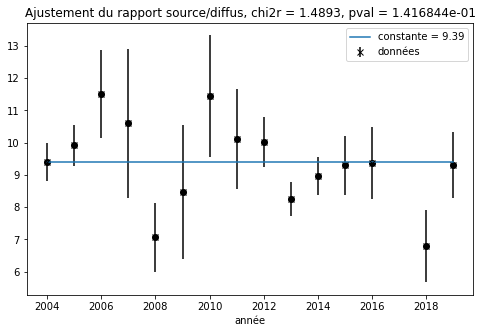

In [57]:
x = years
y = resGC/resdiff


# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(0.6)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y, weights=1.0/y_uncs)


A1 = y
A2 = t(2004)
err_bars = yerr_rap
#chi2, pval = stats.chisquare(A1, A2)
chi2r = chisqr(A1, A2, err_bars)
pv = pval(A1, A2, err_bars)


# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=yerr_rap, fmt='kx', label="données")
plt.plot(x, t(x), label='constante = ' + str(round(t(2004), 3)) )
plt.xlabel('année')
plt.ylabel('')
plt.legend(loc=1)

plt.title("Ajustement du rapport source/diffus, chi2r = {0:03.4f}, pval = {1:e}".format(chi2r, pv))
plt.savefig(path/"fit_flux_GCsurDE_04_19.pdf")